# Hazard: Landslides

The `landslide` class inherits from the `hazard` class and simulates landslides (LS). 

It handles 2 different models: 
* *historic landslides*: historic, point-shaped event sets based on the NASA COOLR global landslide catalogue, continuously updated.
* *probabilistic landslides*: UNEP_NGI - a global probabilistic LS model, based on data from the Norwegian Geotechnical Institute (NGI) for UNEP GRID, last improved 2018.


### Option 1: historic landslide events: NASA COOLR initiative
Data from the global landslide catalogue is continuously updated as part of the Cooperative Open Online Landslide Repository (https://pmm.nasa.gov/landslides/coolrdata.html#download). The data consists in points representing an approximate occurence location, without spatial extent and any kind of "intensity" (binary events).

The most recent version of the dataset should always be downloaded by going to the link > "Open Landslide Viewer" (takes some time to load) > click "Download the full Landslide Catalog" > selecting the "NASA Global Landslide Catalog Points (Shapefile)" for download.

Download and unzip the up-to-date version.

In [1]:
import sys
path_climada = 'your_path_to_climada_python/' #e.g.:'/Users/evelynm/climada_python/'
sys.path.append(path_climada)

In [2]:
# Loading packages
%matplotlib inline
from climada.hazard import Hazard
from climada.hazard import landslide
from climada.hazard.landslide import Landslide
import os

2020-09-17 17:07:34,061 - climada - DEBUG - Loading default config file: /Users/evelynm/climada_python/climada/conf/defaults.conf


The historic landslide events are then directly read into a landslide hazard set.
We create an empty `Landslide()` instance and fill it with all historic data available from the catalog in the desired bounding box.

/Users/evelynm/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


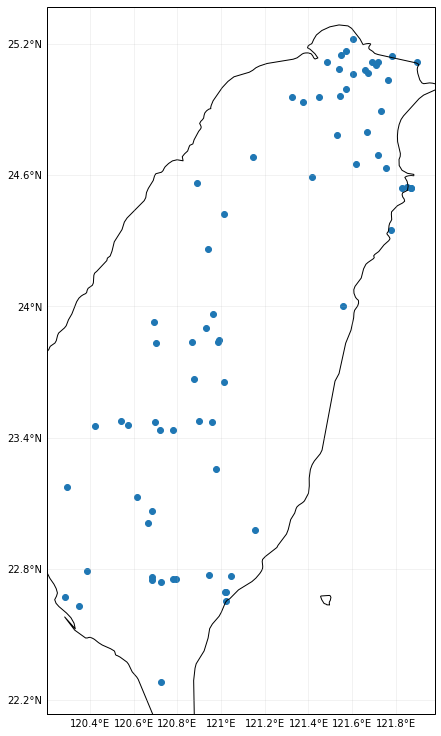

In [3]:
path_COOLR = 'your path to folder nasa_global_landslide_catalog_point' #e.g.: '/Users/evelynm/climada_python/data/system/nasa_global_landslide_catalog_point'
bbox_taiwan = [25.5, 122.0, 21.0, 119.5]

# Example for Taiwan
haz_ls_Taiwan_hist = Landslide()
haz_ls_Taiwan_hist.set_ls_model_hist(bbox=bbox_taiwan, path_sourcefile = path_COOLR, check_plots=1)

In [4]:
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

### Exemplary end-to-end impact calculation using the historic LS option

The steps below follow the normal routine of defining impact functions, getting an exposure, and performing an impact calculation based on the given historic hazard set.

*Impact functions* relate the hazard intensity to a percentage of damage in the exposure. For a detailed description on impact functions, check out the respective tutorial.

Since the historic landslides have no spatial extent, their intensity is simply put to "1" at the respective point of occurrence and a dummy impact function is created for illustrative purposes, where damage (impact) is simply 100% when intensity =1:

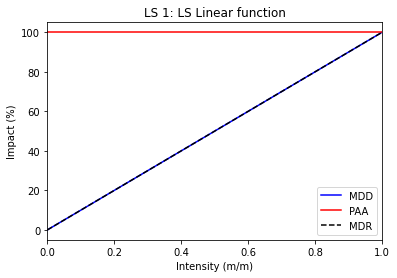

In [5]:
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
if_LS_hist = ImpactFunc() 
if_LS_hist.haz_type = 'LS'
if_LS_hist.id = 1
if_LS_hist.name = 'LS Linear function'
if_LS_hist.intensity_unit = 'm/m'
if_LS_hist.intensity = np.linspace(0, 1, num=15)
if_LS_hist.mdd = np.sort(np.linspace(0, 1, num=15))
if_LS_hist.paa = np.sort(np.linspace(1, 1, num=15))
if_LS_hist.check()
if_LS_hist.plot()
ifset_LS_hist = ImpactFuncSet()
ifset_LS_hist.append(if_LS_hist)

For a detailed description of the *Exposure* class, refer to the respective tutorial.
This LS tutorial uses the LitPop class, which models countries' gridded asset exposure by disaggregating a macroeconomic indicator (e.g. total asset value or GDP) proportional to the product of night light intensities ("Lit") and gridded population count ("Pop") per country.  

2020-09-17 17:08:05,004 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2020-09-17 17:08:17,651 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.13
2020-09-17 17:08:31,340 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2020-09-17 17:08:31,341 - climada.util.finance - WARNING - GDP data for TWN is not provided by World Bank.                        Instead, IMF data is returned here.
2020-09-17 17:08:32,007 - climada.entity.exposures.litpop - INFO - Creating the LitPop exposure took 28 s
2020-09-17 17:08:32,008 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-09-17 17:08:32,008 - climada.entity.exposures.base - INFO - centr_ not set.
2020-09-17 17:08:32,008 - climada.entity.exposures.base - INFO - deductible not set.
2020-09-17 17:08:32,009 - climada.entity.exposures.base - INFO - cover not set.
2020-09-17 17:08:32,009 - climada.entity.exposures.bas

/Users/evelynm/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-09-17 17:08:43,857 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


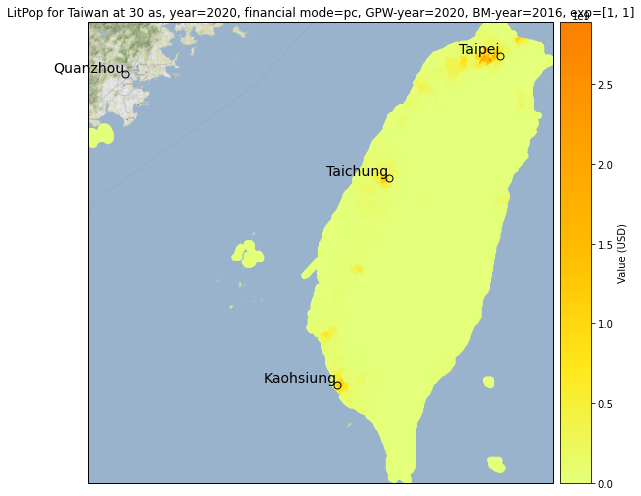

In [6]:
# Set LitPop exposure for Taiwan
exp_LS_hist = LitPop()
exp_LS_hist.set_country('Taiwan', reference_year = 2020)
exp_LS_hist.set_geometry_points()
exp_LS_hist.rename({'if_': 'if_LS'}, axis='columns')
exp_LS_hist = Exposures(exp_LS_hist)
exp_LS_hist.set_lat_lon()
exp_LS_hist.check()

# plot the exposure
exp_LS_hist.plot_basemap()

In [7]:
# Set Entity    
ent_LS_hist = Entity()
ent_LS_hist.exposures = exp_LS_hist
ent_LS_hist.impact_funcs = ifset_LS_hist
exp_LS_hist.assign_centroids(haz_ls_Taiwan_hist, method='NN', distance='haversine',threshold=1)

2020-09-17 17:08:47,519 - climada.entity.exposures.base - INFO - Matching 46165 exposures with 73 centroids.
2020-09-17 17:08:47,747 - climada.util.interpolation - WARNING - Distance to closest centroid is greater than 1km for 45902 coordinates.


2020-09-17 17:08:49,572 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LS
2020-09-17 17:08:49,578 - climada.engine.impact - INFO - Calculating damage for 263 assets (>0) and 73 events.
2020-09-17 17:08:49,579 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.
2020-09-17 17:08:49,596 - climada.util.coordinates - INFO - Raster from resolution 0.008333333333240489 to 0.008333333333240489.


/Users/evelynm/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


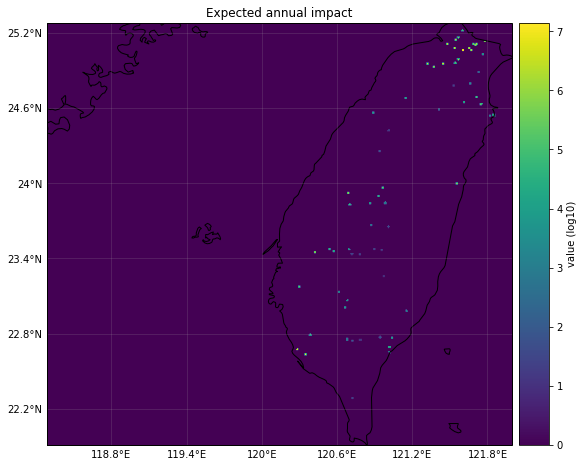

In [8]:
# Impact calculation from historic landslides, with exposure and impact function defined as above.
imp_LS_Taiwan_hist = Impact()
imp_LS_Taiwan_hist.calc(ent_LS_hist.exposures, ent_LS_hist.impact_funcs, haz_ls_Taiwan_hist)
imp_LS_Taiwan_hist.plot_raster_eai_exposure()

### Option 2:  probabilistic landslide hazard from UNEP / NGI

The global probabilistic hazardset is provided publicly by UNEP GRID and was developed by the Norwegian Geotechnical Institute (NGI); see https://preview.grid.unep.ch/index.php?preview=data&events=landslides&evcat=2&lang=eng for details. It has units of expected annual probability and percentage of pixel of occurrence of a potentially destructive landslide event x 1000000 and includes an estimate of the annual frequency of landslide triggered by precipitations. It depends on the combination of trigger and susceptibility defined by six parameters: slope factor, lithological (or geological) conditions, soil moisture condition, vegetation cover, precipitation and seismic conditions.

For the CLIMADA hazard set, the occurrence probabilities for each pixel of the raw dataset are converted into binary events. Where a landslide occurs is determined  based on a binomial distribution with p = probability of LS occurrence in the respective pixel and n = number of years in the simulation.

In [9]:
# Loading packages
%matplotlib inline
from climada.hazard import Hazard
from climada.hazard import landslide
from climada.hazard.landslide import Landslide
import os

2020-09-17 17:12:46,834 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/data/system/ls_pr_NGI_UNEP/ls_pr.tif
2020-09-17 17:13:20,348 - climada.hazard.landslide - INFO - Generating landslides...


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


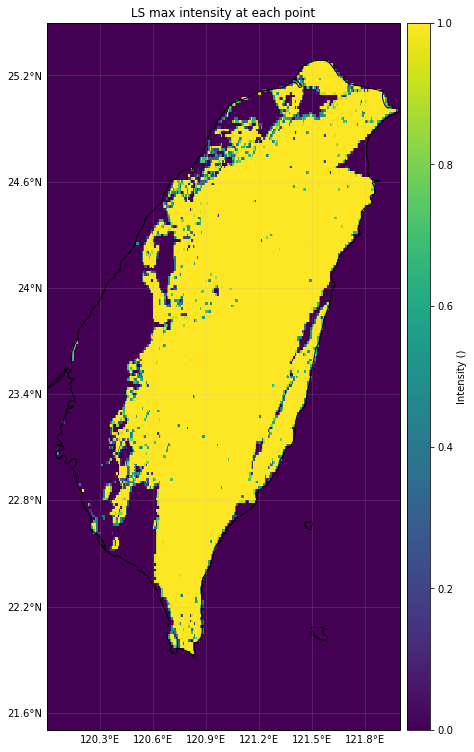

In [14]:
haz_ls_taiwan_prob = Landslide()
bbox_taiwan = [25.5, 122.0, 21.5, 120.0]
haz_ls_taiwan_prob.set_ls_model_prob(bbox=bbox_taiwan, check_plots=1)

With the hazard set loaded, it is now possible to calculate the expected damage for the simulated period:

In [11]:
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

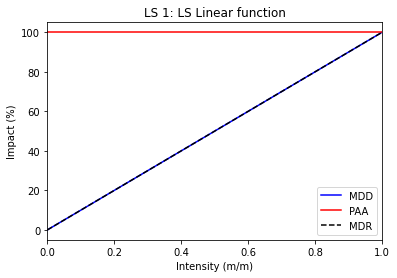

In [12]:
# Set impact function
if_LS_prob = ImpactFunc() 
if_LS_prob.haz_type = 'LS'
if_LS_prob.id = 1
if_LS_prob.name = 'LS Linear function'
if_LS_prob.intensity_unit = 'm/m'
if_LS_prob.intensity = np.linspace(0, 1, num=15)
if_LS_prob.mdd = np.sort(np.linspace(0, 1, num=15))
if_LS_prob.paa = np.sort(np.linspace(1, 1, num=15))
if_LS_prob.check()
if_LS_prob.plot()
ifset_LS_prob = ImpactFuncSet()
ifset_LS_prob.append(if_LS_prob)

2020-09-17 17:10:32,077 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2020-09-17 17:10:44,820 - climada.entity.exposures.gpw_import - INFO - Reference year: 2019. Using nearest available year for GWP population data: 2020
2020-09-17 17:10:44,821 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.13
2020-09-17 17:10:55,615 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2020-09-17 17:10:55,616 - climada.util.finance - WARNING - GDP data for TWN is not provided by World Bank.                        Instead, IMF data is returned here.
2020-09-17 17:10:56,284 - climada.entity.exposures.litpop - INFO - Creating the LitPop exposure took 25 s
2020-09-17 17:10:56,285 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2020-09-17 17:10:56,285 - climada.entity.exposures.base - INFO - centr_ not set.
2020-09-17 17:10:56,285 - climada.entity.exposures.base - INFO - de

/Users/evelynm/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-09-17 17:11:04,071 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


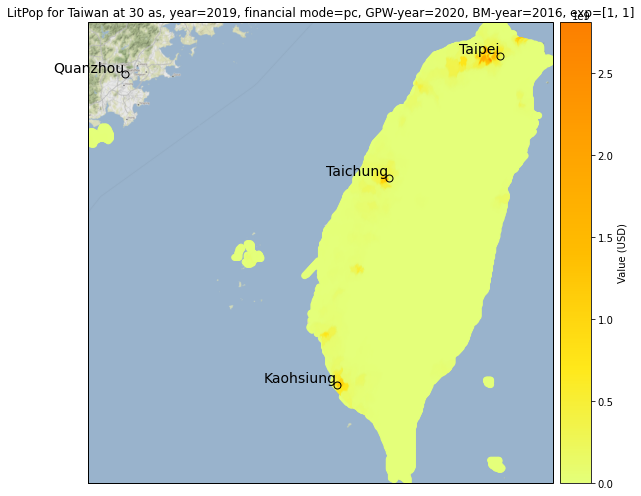

In [13]:
# Set exposure for Taiwan:
exp_LS_prob = LitPop()
exp_LS_prob.set_country('Taiwan', reference_year = 2019)
exp_LS_prob.set_geometry_points()
exp_LS_prob.rename({'if_': 'if_LS'}, axis='columns')
exp_LS_prob = Exposures(exp_LS_prob)
exp_LS_prob.set_lat_lon()
exp_LS_prob.check()

# plot exposure
exp_LS_prob.plot_basemap()

In [16]:
# Set Entity    
ent_LS_prob = Entity()
ent_LS_prob.exposures = exp_LS_prob
ent_LS_prob.impact_funcs = ifset_LS_prob

2020-09-17 17:13:39,931 - climada.entity.exposures.base - INFO - Matching 46165 exposures with 115200 centroids.
2020-09-17 17:13:39,940 - climada.engine.impact - INFO - Calculating damage for 45801 assets (>0) and 33501 events.
2020-09-17 17:13:39,941 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.
2020-09-17 17:13:39,973 - climada.util.coordinates - INFO - Raster from resolution 0.008333333333240489 to 0.008333333333240489.


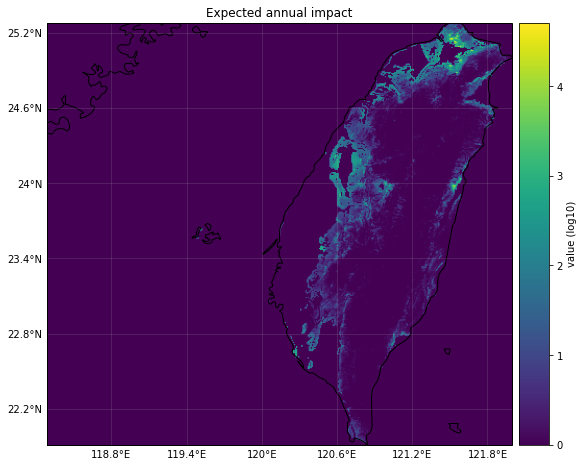

In [17]:
# Set impact for probabilistic simulation
imp_LS_Taiwan_prob_I = Impact()
imp_LS_Taiwan_prob_I.calc(ent_LS_prob.exposures, ent_LS_prob.impact_funcs, haz_ls_taiwan_prob)
imp_LS_Taiwan_prob_I.plot_raster_eai_exposure()

Last remark: Be aware that this is the *expected annual impact (AED)*, given that the hazard set incorporates *annual* probabilities of an event.

Notizen Jan:
Hist:
Im hist Model gibt es einige intressante Attribute.
ls_size: attribut welches die grosse beschreibt [small, medium, large]
ls_cat: die Kategory [landslide, rock_fall, mudslide, debris_flow,...]
ls_triger: Auslöser für LS [downpour, tropycal_cyclone, freeze_thaw, ...]

Warnung: Missing exposures impact functions for hazard "if_LS" Using impact functions in "if_".
Problem: Durch ungenauigkeit sind (vermutlich) ein paar ls über Wasser (exposure = 0).
